In [1]:
import sys, os

sys.path.insert(0, '/home/daniil/repos/pytorch-segmentation-detection/vision/')
sys.path.append('/home/daniil/repos/pytorch-segmentation-detection/')

import torch
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.autograd import Variable


from pytorch_segmentation_detection.datasets.detection.pascal_voc import PascalVOCDetection

from pytorch_segmentation_detection.models.detection.resnet_dilated import Resnet18_16s


transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))
    ])

dataset = PascalVOCDetection(annotation_json='/home/daniil/projects/pascal/PASCAL_VOC/pascal_val2012.json',
                             images_folder_path='/home/daniil/projects/pascal/dataset/VOCdevkit/VOC2012/JPEGImages/',
                             image_transform=transform)


trainloader = torch.utils.data.DataLoader(dataset, batch_size=30,
                                          shuffle=True, num_workers=2)

#compute the number of anchor boxes (9) + number of classes (20) + background = 30

anchors_per_cell = 9
number_of_classes = 21

number_of_anchors_outputs = anchors_per_cell * 4
number_of_classes_outputs = anchors_per_cell * number_of_classes

output_size = number_of_anchors_outputs + number_of_classes_outputs

model = Resnet18_16s(num_classes=output_size).cuda().train()

classification_criterion = torch.nn.CrossEntropyLoss(ignore_index=-1).cuda()

regression_criterion = torch.nn.SmoothL1Loss().cuda()

learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loading annotations into memory...
Done (t=0.13s)
creating index...
index created!


/home/daniil/repos/anaconda2/lib/python2.7/site-packages/torch/nn/modules/module.py:482: UserWarning: src is not broadcastable to dst, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  own_state[name].copy_(param)


<IPython.core.display.Javascript object>


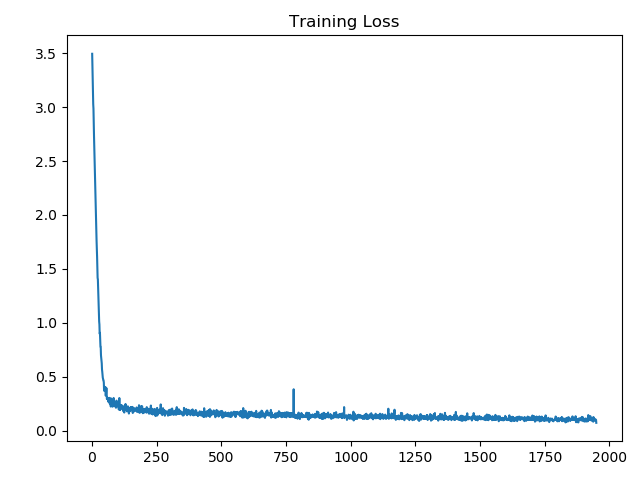

In [2]:
%matplotlib notebook

from pytorch_segmentation_detection.utils.visualization import VizList
from matplotlib import pyplot as plt

# Creating figure, axes and binding to lists 
f, loss_axis = plt.subplots(1, 1)

loss_axis.plot([], [])

loss_list = VizList()

loss_list.bind_to_axis(loss_axis)

loss_axis.set_title('Training Loss')

plt.tight_layout()

In [3]:
epochs_number = 10


for epochs_number in xrange(epochs_number):
    
    for batch in trainloader:

            image_batch_var = Variable(batch[0].cuda())
            regression_gt = batch[1]
            classification_gt = batch[2]

            optimizer.zero_grad()

            output_tensor = model.forward(image_batch_var)

            # (2, 9*4, 38, 38)
            regression_output = output_tensor[:, :number_of_anchors_outputs, :]

            # (2, 9*21, 38, 38)
            classification_output = output_tensor[:, number_of_anchors_outputs:, :]

            # ---- Prepare the classification 

            # (2, 38, 38, 9)
            classification_gt_aligned = classification_gt.permute(0, 2, 3, 1).contiguous()


            # (2, 38, 38, 9*21)
            classification_output_aligned = classification_output.permute(0, 2, 3, 1).contiguous()

            classification_output_aligned_shape = list(classification_output_aligned.shape)
            classification_output_aligned_shape[-1] = anchors_per_cell
            classification_output_aligned_shape.append(number_of_classes)

            # (2, 38, 38, 9, 21)
            classification_output_aligned = classification_output_aligned.view(classification_output_aligned_shape)

            # (2 * 38 * 38 * 9, 21)
            classification_output_aligned = classification_output_aligned.view((-1, number_of_classes))

            # (2 * 38 * 38 * 9)
            classification_gt_aligned = Variable( classification_gt_aligned.view((-1)).cuda() )

            # Last two variables can be plugged into cross entropy loss

            classification_loss = classification_criterion(classification_output_aligned, classification_gt_aligned)

            # ---- Prepare the regression

            regression_gt_aligned = Variable( regression_gt.view_as(regression_output).contiguous().cuda() )

            regression_output_aligned = regression_output

            regression_loss = regression_criterion(regression_output_aligned, regression_gt_aligned)

            overall_loss = classification_loss + regression_loss

            overall_loss.backward()

            optimizer.step()

            loss_list.append( overall_loss.data[0] )

In [4]:
torch.save(model.state_dict(), 'resnet_18_16s_detection.pth')

In [2]:
# Test the model

# the model outputs the delta values for each bounding box
# and class -- we can easily test the class prediction I guess

dataset.pascal_cocolike_db.coco.cats

{1: {u'id': 1, u'name': u'aeroplane', u'supercategory': u'none'},
 2: {u'id': 2, u'name': u'bicycle', u'supercategory': u'none'},
 3: {u'id': 3, u'name': u'bird', u'supercategory': u'none'},
 4: {u'id': 4, u'name': u'boat', u'supercategory': u'none'},
 5: {u'id': 5, u'name': u'bottle', u'supercategory': u'none'},
 6: {u'id': 6, u'name': u'bus', u'supercategory': u'none'},
 7: {u'id': 7, u'name': u'car', u'supercategory': u'none'},
 8: {u'id': 8, u'name': u'cat', u'supercategory': u'none'},
 9: {u'id': 9, u'name': u'chair', u'supercategory': u'none'},
 10: {u'id': 10, u'name': u'cow', u'supercategory': u'none'},
 11: {u'id': 11, u'name': u'diningtable', u'supercategory': u'none'},
 12: {u'id': 12, u'name': u'dog', u'supercategory': u'none'},
 13: {u'id': 13, u'name': u'horse', u'supercategory': u'none'},
 14: {u'id': 14, u'name': u'motorbike', u'supercategory': u'none'},
 15: {u'id': 15, u'name': u'person', u'supercategory': u'none'},
 16: {u'id': 16, u'name': u'pottedplant', u'supercat